In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# load labels and read in image information
# the images are small enough to load them all into the memory rather than use an image-loading generator
path = '../input/train/train/'
df = pd.read_csv('../input/train.csv')
n = len(df)
y = np.zeros(shape=(n,1),dtype=int)
X = np.zeros(shape=(n,32,32,3))

for i,v in df.iterrows():
    y[i] = v[1]
    X[i] = (mpimg.imread(f'{path}/{v[0]}'))/255

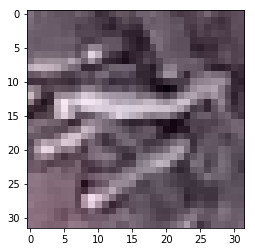

[1]


In [3]:
# show one image
i = np.random.randint(len(X))
plt.imshow(X[i])
plt.show()
print(y[i])

In [5]:
# add permuations (flips and rotation)
X_vflip = np.zeros(shape=(n,32,32,3))
X_hflip = np.zeros(shape=(n,32,32,3))
X_rot = np.zeros(shape=(n,32,32,3))
for i in range(n):
    X_vflip[i] = np.flip(X[i],axis=0)
    X_hflip[i] = np.flip(X[i],axis=1)
    X_rot[i] = np.rot90(X[i])

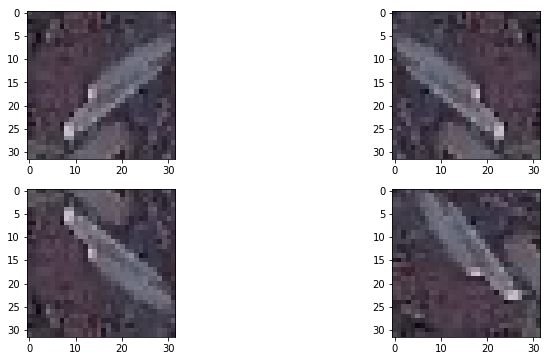

[1]


In [9]:
# observe a random permutation:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,6))
i = np.random.randint(len(X))
ax[0,0].imshow(X[i])
ax[1,0].imshow(X_vflip[i])
ax[0,1].imshow(X_hflip[i])
ax[1,1].imshow(X_rot[i])
plt.show()
print(y[i])

In [6]:
# after initial testing, there is no more need for testing, and the entire dataset will probably yield better predictions

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
# combined permuations with data:
X_all = np.concatenate((X,X_vflip,X_hflip,X_rot))
y_all = np.concatenate((y,y,y,y))

In [11]:
# generate model
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Flatten, MaxPooling2D, Dropout

Using TensorFlow backend.


In [12]:
input_layer = Input(shape=(32,32,3))
x = Convolution2D(16, kernel_size=3,activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Convolution2D(32, kernel_size=3,activation='relu')(x)
x = Convolution2D(64, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Dense(256,activation='relu')(Flatten()(x))
x = Dropout(rate=0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxP

In [13]:
# train model on all data including permutations
model.fit(X_all,y_all,epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
70000/70000 [==============================] - 63s 900us/step - loss: 0.1166 - acc: 0.9568
Epoch 2/10
70000/70000 [==============================] - 63s 896us/step - loss: 0.0609 - acc: 0.9778
Epoch 3/10
70000/70000 [==============================] - 62s 883us/step - loss: 0.0439 - acc: 0.9842
Epoch 4/10
70000/70000 [==============================] - 62s 888us/step - loss: 0.0312 - acc: 0.9891
Epoch 5/10
70000/70000 [==============================] - 62s 882us/step - loss: 0.0240 - acc: 0.9918
Epoch 6/10
70000/70000 [==============================] - 62s 883us/step - loss: 0.0220 - acc: 0.9925
Epoch 7/10
70000/70000 [==============================] - 62s 892us/step - loss: 0.0173 - acc: 0.9938
Epoch 8/10
70000/70000 [==============================] - 62s 882us/step - loss: 0.0171 - acc: 0.9939
Epoch 9/10
70000/70000 [==============================] - 62s 884us/step - loss: 0.0146 - acc: 0.9949
Epoch 10/10
70000/70000 [=========

In [14]:
# originally was used on the test set, but now that I have used the entire dataset, this is not useful
#model.evaluate(X_test,y_test)

In [15]:
# read in submission (test) images
tpath = '../input/test/test/'
submit = pd.read_csv('../input/sample_submission.csv')
t_X = np.zeros(shape=(len(submit),32,32,3))

for i,v in submit.iterrows():
    t_X[i] = (mpimg.imread(f'{tpath}/{v[0]}'))/255

In [16]:
# get predictions
t_y = model.predict(t_X)

In [17]:
# insert predictions in submission file
submit['has_cactus'] = t_y
submit.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.999308
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.000000
2,001ee6d8564003107853118ab87df407.jpg,0.003401
3,002e175c3c1e060769475f52182583d0.jpg,0.000356
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.122662


In [18]:
# save output for submission
submit.to_csv('170419_perm.csv',index=False)